#**LABORATORIO 03 - REDES CONVOLUCIONALES**

##Nombre: Gonzales Suyo Franz Reinaldo

##C.U. 111-500

##Link GitHub: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-03_CNN

##CONTEXTO DEL LABORATORIO

Elaborar:

1. Con el dataset elaborado, construir una red neuronal convolucional que permita identificar (clasificar) las diferentes plantas medicinales que se puedan obtener a partir de una imagen fotografica, es decir se deben utilizar el dataset para entrenar y validar la efectividad del modelo desarrollado, se debe aplicar las tenicas que considere necesarias de las revisadas para lograr obtener los mejores parametros para el modelo. Las pruebas de la efectividad se realizaran con imagenes que se capturaran con una camara fotográfica.


2. Realizar lo solicitado en el punto 1, pero utilizando un modelo preentrenado y aplicando tecnicas de transfer learning y fine tunning.

Se debe elaborar un informe en relacion a los resultados que se obtengan en cada parte del trabajo.

El cuadernillo a presentar solo debe tener informacion que el estudiante considere necesaria.

Se debe subir el cuadernillo a ecampus y a su repositorio, para lo cual se debe incluir la dirección del mismo.

Se recomienda realizar un trabajo responsable y detallado, por cuanto este trabajo tiene una calificación especial y es parte del examen del primer parcial, por lo cual codigos que se identifiquen copia o no sean adecuadamente defendidos seran considerados como copia o no validos.

In [1]:
# DESCARGAMOS LAS LIBRERIAS
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


##1. Preparación del Dataset

Nuestro dataset es sobre 5 tipos de plantas medicinales, que son mas de 75000 imagenes, en este post aplicaremos todos las tecnicas que se aplican para contruir un modelo de red convolucional.

Nuestro dataset cuenta con 5 tipos de clases: Acelga, Cebolla, Espinaca, Lechuga y Toronjil.


In [9]:
""""
Leemos el Dataset para trabajar en base de ello, ademas aplicamos las buenas prácticas
como las transformaciones de las imagenes y redimencionamiento a un 50x50 píxeles.
"""

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])

# Cargar los datasets de entrenamiento y prueba
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de prueba: 15000


Mostamos alguans imagenes que se capturan a partir de los datos, cada imagen se visualiza com sus respectivas clases.

In [4]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalización de las imágenes
])

# Función para limitar el número de archivos de cada subcarpeta
def limit_dataset_size(root_dir, max_per_class=6000):
    # Diccionario para almacenar rutas de las imágenes seleccionadas por clase
    limited_dataset = []

    # Iteramos por las subcarpetas en root_dir (cada subcarpeta es una clase)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Obtenemos todas las imágenes en la subcarpeta
            all_images = os.listdir(class_dir)
            # Filtramos para obtener solo imágenes, excluyendo otros tipos de archivos
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Seleccionamos aleatoriamente 6000 imágenes
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset



In [5]:
# Definir la ruta del dataset
root_dir = '/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train'

# Obtener una lista de las rutas de imágenes limitadas a 6000 por clase
limited_image_paths = limit_dataset_size(root_dir, max_per_class=6000)

# Clase personalizada para cargar solo las imágenes seleccionadas
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, selected_files, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # Filtrar el dataset para cargar solo las imágenes seleccionadas
        self.samples = [(os.path.join(root, img), self.class_to_idx[img.split('/')[0]]) for img in selected_files]
        self.targets = [s[1] for s in self.samples]  # Extraer las etiquetas

# Crear el dataset personalizado usando solo las imágenes seleccionadas
train_data = CustomImageFolder(root=root_dir, selected_files=limited_image_paths, transform=transform)

# Verificar el número de imágenes en el nuevo conjunto de entrenamiento
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verificar el número de imágenes por clase
from collections import Counter
print("Distribución de imágenes por clase:", Counter(train_data.targets))

Número total de imágenes en el nuevo conjunto de entrenamiento: 30000
Distribución de imágenes por clase: Counter({0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000})


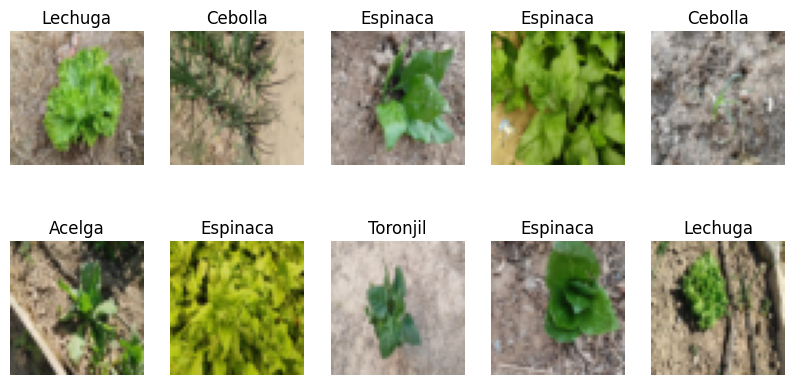

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

##Preparamos el DATALOADER

In [10]:
# Preparar los DataLoaders en formato de diccionario
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

# Mostrar la cantidad de imágenes de entrenamiento y prueba
# print(f"Número de imágenes de entrenamiento: {len(train_data)}")
# print(f"Número de imágenes de prueba: {len(test_data)}")

##2. Diseño de la Red Convolucional

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

# Bloques de convolución + activación + max pooling + batch normalization
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=k, padding=p, stride=s),
        nn.BatchNorm2d(c_out),  # Batch Normalization
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=pk, stride=ps)
    )

# Bloques de capas totalmente conectadas
def block2(c_in, c_out, dropout_p=0.5):
    return nn.Sequential(
        nn.Linear(c_in, c_out),
        nn.ReLU(),
        nn.Dropout(dropout_p)  # Dropout para regularización
    )

class CNN(nn.Module):
    def __init__(self, n_channels=3, n_outputs=5):
        super().__init__()

        # Capas convolucionales con batch normalization
        self.conv1 = block(n_channels, 32)
        self.conv2 = block(32, 64)
        self.conv3 = block(64, 128)

        # Capas fully connected con Dropout
        self.fc1 = block2(128 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, n_outputs)

    def forward(self, x):
        # Capas convolucionales
        # print("Dimensiones:")
        # print("Entrada: ", x.shape)
        x = self.conv1(x)
        # print("conv1: ", x.shape)
        x = self.conv2(x)
        # print("conv2: ", x.shape)
        x = self.conv3(x)
        # print("conv3: ", x.shape)

        # Aplanar para las fully connected
        x = x.view(x.shape[0], -1)
        # print("pre fc: ", x.shape)

        # Capas fully connected
        x = self.fc1(x)
        x = self.fc2(x)
        # print("Salida: ", x.shape)

        return x


In [22]:
# Crear el modelo
model = CNN()

In [14]:

# Probar el modelo con un lote de imágenes de entrada simuladas de 50x50 y 3 canales
# (ya que el dataset tiene imágenes RGB)
output = model(torch.randn(64, 3, 50, 50))
print(output.shape)


Dimensiones:
Entrada:  torch.Size([64, 3, 50, 50])
conv1:  torch.Size([64, 32, 25, 25])
conv2:  torch.Size([64, 64, 12, 12])
conv3:  torch.Size([64, 128, 6, 6])
pre fc:  torch.Size([64, 4608])
Salida:  torch.Size([64, 5])
torch.Size([64, 5])


##3. Entrenamiento del Modelo

In [15]:
# Directorio donde se guardarán los checkpoints
checkpoint_dir = "/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/"

# Función para guardar un checkpoint en la ruta especificada
def save_checkpoint(epoch, model, optimizer, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    full_path = os.path.join(checkpoint_dir, filename)  # Construir la ruta completa
    torch.save(checkpoint, full_path)
    print(f'Checkpoint guardado en: {full_path}')


In [23]:
def fit(model, dataloader, epochs=10, lr=1e-3, weight_decay=1e-4, save_interval=5):
    """
    Entrenamiento del modelo con optimizaciones, regularización y guardado de checkpoints.

    Args:
    - model: El modelo de CNN.
    - dataloader: Diccionario que contiene los dataloaders de 'train' y 'test'.
    - epochs: Número de épocas de entrenamiento.
    - lr: Learning rate inicial.
    - weight_decay: Tasa de regularización L2.
    - save_interval: Intervalo de épocas para guardar los checkpoints.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # Optimizador Adam con L2 regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)  # Scheduler para reducir el LR
    criterion = torch.nn.CrossEntropyLoss()  # Pérdida

    for epoch in range(1, epochs + 1):
        # Entrenamiento
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'], desc=f"Epoch {epoch}/{epochs}")

        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)

            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)

            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        # Validación
        model.eval()
        val_loss, val_acc = [], []
        bar = tqdm(dataloader['test'], desc=f"Validation")

        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)

                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)

                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

        # Reducir el learning rate si no mejora la validación
        scheduler.step(np.mean(val_loss))

        # Imprimir métricas de entrenamiento y validación
        print(f"Epoch {epoch}/{epochs} - loss: {np.mean(train_loss):.5f}, val_loss: {np.mean(val_loss):.5f}, "
              f"acc: {np.mean(train_acc):.5f}, val_acc: {np.mean(val_acc):.5f}")

        # Guardar un checkpoint cada 'save_interval' epochs
        if epoch % save_interval == 0:
            checkpoint_filename = f"checkpoint_epoch_{epoch}.pth"
            save_checkpoint(epoch, model, optimizer, np.mean(val_loss), filename=checkpoint_filename)

In [25]:
# Suponiendo que ya tengas el modelo y los dataloaders preparados:
fit(model, dataloader, epochs=10, lr=1e-3, weight_decay=1e-4, save_interval=2)


val_loss 0.04444 val_acc 0.98280: 100%|██████████| 235/235 [1:27:23<00:00, 22.31s/it]


Epoch 1/10 - loss: 0.11204, val_loss: 0.04444, acc: 0.96152, val_acc: 0.98280


val_loss 0.01090 val_acc 0.99634: 100%|██████████| 235/235 [05:05<00:00,  1.30s/it]


Epoch 2/10 - loss: 0.05604, val_loss: 0.01090, acc: 0.98101, val_acc: 0.99634
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_2.pth


val_loss 0.02011 val_acc 0.99328: 100%|██████████| 235/235 [05:14<00:00,  1.34s/it]


Epoch 3/10 - loss: 0.04143, val_loss: 0.02011, acc: 0.98641, val_acc: 0.99328


val_loss 0.02400 val_acc 0.99218: 100%|██████████| 235/235 [05:24<00:00,  1.38s/it]


Epoch 4/10 - loss: 0.03555, val_loss: 0.02400, acc: 0.98764, val_acc: 0.99218
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_4.pth


val_loss 0.02833 val_acc 0.99242: 100%|██████████| 235/235 [05:31<00:00,  1.41s/it]


Epoch 5/10 - loss: 0.02694, val_loss: 0.02833, acc: 0.99126, val_acc: 0.99242


val_loss 0.21744 val_acc 0.96436: 100%|██████████| 235/235 [05:35<00:00,  1.43s/it]


Epoch 6/10 - loss: 0.02830, val_loss: 0.21744, acc: 0.99158, val_acc: 0.96436
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_6.pth


val_loss 0.00050 val_acc 0.99987: 100%|██████████| 235/235 [05:19<00:00,  1.36s/it]


Epoch 7/10 - loss: 0.00904, val_loss: 0.00050, acc: 0.99713, val_acc: 0.99987


val_loss 0.00036 val_acc 0.99987: 100%|██████████| 235/235 [05:25<00:00,  1.38s/it]


Epoch 8/10 - loss: 0.00455, val_loss: 0.00036, acc: 0.99850, val_acc: 0.99987
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_8.pth


val_loss 0.00030 val_acc 0.99987: 100%|██████████| 235/235 [05:24<00:00,  1.38s/it]


Epoch 9/10 - loss: 0.00388, val_loss: 0.00030, acc: 0.99873, val_acc: 0.99987


val_loss 0.00028 val_acc 0.99987: 100%|██████████| 235/235 [05:32<00:00,  1.42s/it]


Epoch 10/10 - loss: 0.00282, val_loss: 0.00028, acc: 0.99927, val_acc: 0.99987
Checkpoint guardado en: /content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_10.pth


##Evaluación del Modelo

In [26]:
def evaluate(model, dataloader):
    """
    Evalúa el modelo en un conjunto de datos (dataloader).
    Retorna la pérdida promedio y la precisión promedio.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()  # Modo de evaluación
    val_loss, val_acc = [], []  # Inicializar listas para almacenar pérdida y precisión
    criterion = torch.nn.CrossEntropyLoss()  # Función de pérdida

    with torch.no_grad():  # No calcular gradientes durante la evaluación
        for batch in tqdm(dataloader, desc="Evaluating"):  # Progreso de evaluación
            X, y = batch  # Obtener el batch de datos y etiquetas
            X, y = X.to(device), y.to(device)  # Mover los datos al dispositivo (GPU/CPU)

            y_hat = model(X)  # Realizar predicciones
            loss = criterion(y_hat, y)  # Calcular la pérdida

            val_loss.append(loss.item())  # Almacenar la pérdida del batch
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)  # Calcular la precisión
            val_acc.append(acc)  # Almacenar la precisión del batch

    # Calcular la pérdida y precisión promedio
    avg_loss = np.mean(val_loss)
    avg_acc = np.mean(val_acc)

    print(f"Evaluation - loss: {avg_loss:.5f}, acc: {avg_acc:.5f}")
    return avg_loss, avg_acc


In [27]:
# Evaluar el modelo en el conjunto de prueba
evaluate(model, dataloader['test'])


Evaluating: 100%|██████████| 235/235 [05:27<00:00,  1.39s/it]

Evaluation - loss: 0.00028, acc: 0.99987


(0.00027713906446118723, 0.9998670212765958)

##CARGAMOS LOS MODELOS ENTRENADOS.



###Cargamos el modelo entrenado

In [28]:
# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

In [ ]:
import torch

# Crear una instancia del modelo (asegúrate de que la arquitectura sea la misma)
model = CNN()  # Reemplaza MLP con la clase de tu modelo si es diferente

# Cargar los pesos del modelo guardado
model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/checkpoint_epoch_10.pth'))

# Mover el modelo al dispositivo adecuado (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


<ipython-input-8-5b563bb34a2f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/model

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

##4. Validación del Modelo

In [29]:
# Cambiar el modelo al modo de evaluación
model.eval()

# Inicializar las variables para contar las predicciones correctas
correct = 0
total = 0

with torch.no_grad():
    # Verificar si el DataLoader está vacío
    if len(dataloader['test']) == 0:
        print("Error: test_loader1 está vacío. Verifica la creación del DataLoader.")
    else:
        # Imprimir el tamaño del conjunto de datos de prueba
        print("Tamaño del conjunto de datos de prueba:", len(dataloader['test'].dataset))
        for images, labels in dataloader['test']:
            images, labels = images.to(device), labels.to(device)

            # Realizar predicciones
            outputs = model(images)

            # Obtener la clase con la mayor probabilidad
            _, predicted = torch.max(outputs.data, 1)

            # Contar el número de predicciones correctas
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

# Calcular y mostrar la precisión
if total > 0:
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f} %')
else:
    print("No se pudo calcular la precisión debido a que no hay datos en test_loader1.")

Tamaño del conjunto de datos de prueba: 15000
Accuracy of the model on the test images: 99.99 %


##PRUEBAS CON UNA IMAGEN FOTOGRÁFICA


In [30]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Definir las transformaciones para las imágenes (debe coincidir con las del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((50, 50)),  # Reducir el tamaño de la imagen a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar los tensores
])


In [ ]:
# Cargar el modelo entrenado
model = CNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/plants_cnn_final.pth'))
model.eval()

In [39]:
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=4608, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.

In [31]:
# Función para hacer predicciones
def predict_image(image_path):
    # Cargar la imagen
    image = Image.open(image_path)

    # Aplicar las transformaciones
    image_tensor = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch

    # Realizar la predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()



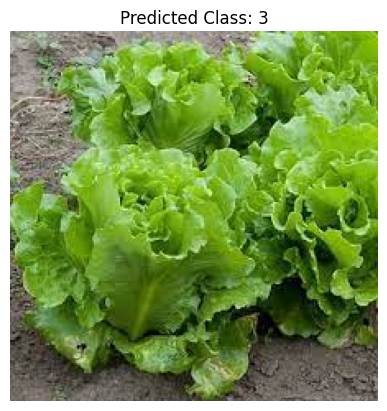

In [37]:
# Ruta de la imagen a probar
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Cambia esto a la ruta de tu imagen
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/cebolla_00386.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/espinaca_00408.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga_00066.jpg'
# image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/toronjil_00022.jpg'
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/lechuga.jpeg'

# Obtener la clase predicha
predicted_class = predict_image(image_path)

# Mostrar la imagen y el resultado
image = Image.open(image_path)
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()

Otra manera de hacer la prueba

In [38]:
# Cargar el modelo y el optimizador desde el checkpoint

# Cargar la imagen para prueba
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Añadir una dimensión para el batch
    return image

# Realizar una prueba con una imagen cargada
def predict(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        return predicted.item()

# Ejemplo de uso
image_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-03/Images_prueba/acelga_08989.jpg'  # Reemplaza con la ruta a tu imagen
predicted_class = predict(image_path)
print(f'Predicted class: {predicted_class}')


Predicted class: 0
